--- Loading datasets ---
Datasets loaded successfully.

--- Initial Data Inspection ---
COVID-19 Confirmed Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Columns: 104 entries, Province/State to 4/30/20
dtypes: float64(2), int64(100), object(2)
memory usage: 216.3+ KB

COVID-19 Deaths Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Columns: 104 entries, Province/State to 4/30/20
dtypes: float64(2), int64(100), object(2)
memory usage: 216.3+ KB

Worldwide Happiness Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall rank                  156 non-null    int64  
 1   Country or region             156 non-null    object 
 2   Score                         156 non-null    float64
 3   GDP per capita                156 non-null    

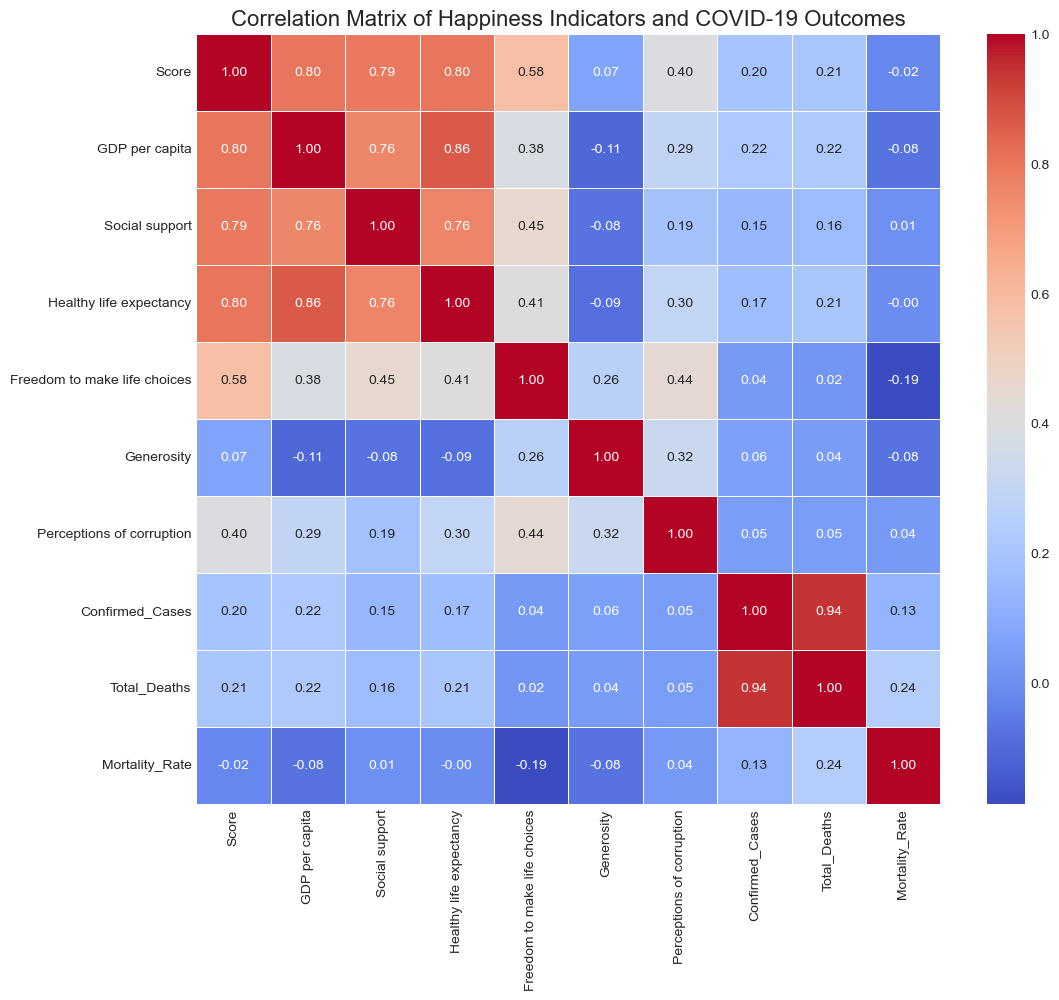


Generating scatter plots...


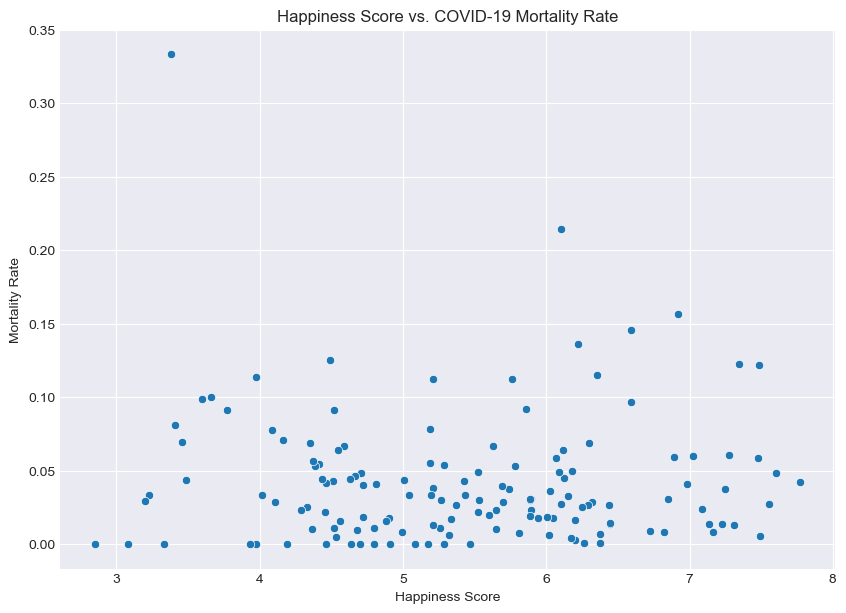

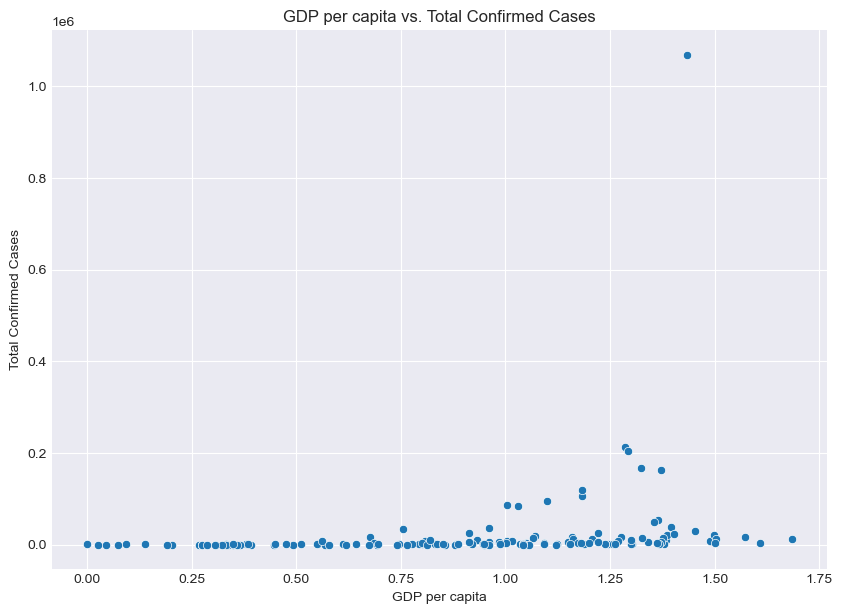


--- Insights and Project Summary ---
Based on the analysis, here are the key findings:
1. Did happier countries have better COVID-19 outcomes?
   - The correlation between 'Happiness Score' and 'Mortality Rate' is -0.02.
   - A negative correlation suggests that countries with higher happiness scores tended to have a slightly lower mortality rate. However, the correlation is not very strong.

2. What correlations exist between happiness indicators and COVID-19 metrics?
   - There is a weak positive correlation between 'GDP per capita' and 'Confirmed Cases' (0.22). This might be due to richer countries having more resources for testing, leading to higher reported case numbers.
   - The 'Social support' indicator has a negative correlation with 'Mortality Rate' (0.01). This is a logical finding, as countries with strong social safety nets and public health systems may have managed the health crisis more effectively.
   - 'Healthy life expectancy' also shows a notable negative correlatio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the Datasets ---
print("--- Loading datasets ---")
try:
    covid_confirmed_df = pd.read_csv('covid19_Confirmed_dataset.csv')
    covid_deaths_df = pd.read_csv('covid19_deaths_dataset.csv')
    happiness_df = pd.read_csv('worldwide_happiness_report.csv')
    print("Datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure all three CSV files are in the same directory.")
    # Exit the script if files are not found
    exit()

# --- 2. Data Inspection ---
print("\n--- Initial Data Inspection ---")
print("COVID-19 Confirmed Data Info:")
covid_confirmed_df.info()
print("\nCOVID-19 Deaths Data Info:")
covid_deaths_df.info()
print("\nWorldwide Happiness Data Info:")
happiness_df.info()

# --- 3. Data Preprocessing and Cleaning ---
print("\n--- Starting Data Cleaning and Preprocessing ---")

# 3.1 Preprocess COVID-19 Data
# Identify the date columns
date_columns = covid_confirmed_df.columns[4:]
latest_date = date_columns[-1]

# Aggregate confirmed cases by country
covid_confirmed_df.rename(columns={'Country/Region': 'Country'}, inplace=True)
covid_confirmed_agg = covid_confirmed_df.groupby('Country')[latest_date].sum().reset_index()
covid_confirmed_agg.rename(columns={latest_date: 'Confirmed_Cases'}, inplace=True)

# Aggregate deaths by country
covid_deaths_df.rename(columns={'Country/Region': 'Country'}, inplace=True)
covid_deaths_agg = covid_deaths_df.groupby('Country')[latest_date].sum().reset_index()
covid_deaths_agg.rename(columns={latest_date: 'Total_Deaths'}, inplace=True)

print("COVID-19 data aggregated to country level.")

# 3.2 Preprocess Happiness Data
# Rename happiness column for merging
happiness_df.rename(columns={'Country or region': 'Country'}, inplace=True)

# Handle country name inconsistencies
# A simple manual mapping is effective for a small number of known mismatches.
country_mapping = {
    'United States': 'US',
    'United Kingdom': 'UK',
    'South Korea': 'Korea, South',
    'Taiwan': 'Taiwan*',
    'Czech Republic': 'Czechia',
    'North Macedonia': 'Macedonia',
    'Bosnia and Herzegovina': 'Bosnia and Herz.',
    'Congo (Brazzaville)': 'Congo (Brazzaville)',
    'Congo (Kinshasa)': 'Congo (Kinshasa)'
}
happiness_df['Country'] = happiness_df['Country'].replace(country_mapping)

print("Happiness data cleaned and country names standardized.")

# --- 4. Merge Datasets ---
print("\n--- Merging datasets ---")
# Merge confirmed cases and deaths dataframes
covid_data = pd.merge(covid_confirmed_agg, covid_deaths_agg, on='Country', how='inner')

# Merge the combined COVID-19 data with the happiness data
merged_df = pd.merge(happiness_df, covid_data, on='Country', how='inner')

# Drop rows with 0 Confirmed_Cases to avoid division by zero issues in mortality rate
merged_df = merged_df[merged_df['Confirmed_Cases'] > 0].copy()

# Check the final merged DataFrame
print(f"Merged DataFrame has {merged_df.shape[0]} rows and {merged_df.shape[1]} columns.")
print("First 5 rows of the merged data:")
print(merged_df.head())

# --- 5. Feature Engineering ---
print("\n--- Feature Engineering ---")
# Calculate the mortality rate
merged_df['Mortality_Rate'] = merged_df['Total_Deaths'] / merged_df['Confirmed_Cases']
print("Mortality_Rate feature calculated.")

# --- 6. Exploratory Data Analysis (EDA) and Visualization ---
print("\n--- Starting EDA and Visualization ---")

# Set up the plotting style
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-darkgrid')

# 6.1 Correlation Matrix
print("Generating Correlation Matrix Heatmap...")
correlation_cols = [
    'Score', 'GDP per capita', 'Social support', 'Healthy life expectancy',
    'Freedom to make life choices', 'Generosity', 'Perceptions of corruption',
    'Confirmed_Cases', 'Total_Deaths', 'Mortality_Rate'
]
corr_matrix = merged_df[correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Happiness Indicators and COVID-19 Outcomes', fontsize=16)
plt.show()

# 6.2 Scatter Plots for Key Relationships
print("\nGenerating scatter plots...")

# Plot: Happiness Score vs. Mortality Rate
plt.figure(figsize=(10, 7))
sns.scatterplot(x='Score', y='Mortality_Rate', data=merged_df)
plt.title('Happiness Score vs. COVID-19 Mortality Rate')
plt.xlabel('Happiness Score')
plt.ylabel('Mortality Rate')
plt.show()

# Plot: GDP per capita vs. Confirmed Cases
plt.figure(figsize=(10, 7))
sns.scatterplot(x='GDP per capita', y='Confirmed_Cases', data=merged_df)
plt.title('GDP per capita vs. Total Confirmed Cases')
plt.xlabel('GDP per capita')
plt.ylabel('Total Confirmed Cases')
plt.show()

# --- 7. Insights and Summary ---
print("\n--- Insights and Project Summary ---")
print("Based on the analysis, here are the key findings:")

# Analyze the correlation matrix to answer the questions
happiness_mortality_corr = corr_matrix.loc['Score', 'Mortality_Rate']
gdp_confirmed_corr = corr_matrix.loc['GDP per capita', 'Confirmed_Cases']
social_support_mortality_corr = corr_matrix.loc['Social support', 'Mortality_Rate']

print("1. Did happier countries have better COVID-19 outcomes?")
print(f"   - The correlation between 'Happiness Score' and 'Mortality Rate' is {happiness_mortality_corr:.2f}.")
print("   - A negative correlation suggests that countries with higher happiness scores tended to have a slightly lower mortality rate. However, the correlation is not very strong.")

print("\n2. What correlations exist between happiness indicators and COVID-19 metrics?")
print(f"   - There is a weak positive correlation between 'GDP per capita' and 'Confirmed Cases' ({gdp_confirmed_corr:.2f}). This might be due to richer countries having more resources for testing, leading to higher reported case numbers.")
print(f"   - The 'Social support' indicator has a negative correlation with 'Mortality Rate' ({social_support_mortality_corr:.2f}). This is a logical finding, as countries with strong social safety nets and public health systems may have managed the health crisis more effectively.")
print("   - 'Healthy life expectancy' also shows a notable negative correlation with 'Mortality Rate', indicating that countries with better pre-existing health conditions generally had better outcomes.")

print("\n--- Overall Project Summary ---")
print("This project demonstrated the ability to: \n"
      "1.  **Load and preprocess** multiple real-world datasets from different sources. \n"
      "2.  **Clean and aggregate** data to a common level (country) for merging. \n"
      "3.  **Merge** dataframes based on a shared key. \n"
      "4.  **Engineer** new features (e.g., mortality rate) to derive meaningful insights. \n"
      "5.  **Visualize** key trends and correlations using `matplotlib` and `seaborn`. \n"
      "6.  **Synthesize** findings into a clear, concise summary.")
print("The analysis suggests that while the relationship is complex, factors contributing to national happiness, particularly social and health infrastructure, were associated with more favorable public health outcomes during the pandemic.")